In [1]:
# the imports required for this notebook
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import sklearn.linear_model
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

import wrangle_module
import model

In [2]:
# acquire and prep using functions in my wrangle_module
permits = wrangle_module.acquire_permits()
permits = wrangle_module.prep_permits(permits)
# permits = wrangle_module.encode_permits(permits)
permits.shape

(67355, 15)

In [3]:
permits.head()

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,Current_Queue,Permit_submitted,Approval_time_days,SHALE,Depth_bin
Permit_approved,,,,,,,,,,,,,,,
2016-01-04,28531642,"CANTERA OPERATING, LLC (129692)",O. A. LAMPLEY GU 1,1,02,LAVACA,Vertical,Recompletion,N,13606,APPROVED,2016-01-04,0,EAGLE FORD,Deep
2016-01-04,46140267,"PARSLEY ENERGY OPERATIONS, LLC (642652)",RATLIFF 28,1D,7C,UPTON,Vertical,New Drill,N,6000,APPROVED,2015-12-31,4,PERMIAN BASIN,Shallow
2016-01-04,30132834,RKI EXPLORATION & PRODUCTION LLC (714221),CBR 4,6H,08,LOVING,Horizontal,New Drill,N,16000,APPROVED,2015-12-31,4,PERMIAN BASIN,Deep
2016-01-04,44331348,HENRY RESOURCES LLC (378535),LAUREN,6201,7C,TERRELL,Vertical,Recompletion,N,12500,APPROVED,2016-01-04,0,PERMIAN BASIN,Deep
2016-01-04,28335696,CABOT OIL & GAS CORPORATION (121700),"SCHORP-WHITE RANCH, LTD. 12H",12H,01,LA SALLE,Horizontal,New Drill,N,8500,APPROVED,2015-12-30,5,EAGLE FORD,Shallow


In [4]:
# double check the datatype on the index
type(permits.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
# get info on the attributes
permits.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67355 entries, 2016-01-04 to 2021-12-30
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   API_NO.               67355 non-null  int64         
 1   Operator_Name_Number  67355 non-null  object        
 2   Lease_Name            67355 non-null  object        
 3   Well                  67355 non-null  object        
 4   District              67355 non-null  object        
 5   County                67355 non-null  object        
 6   Wellbore_Profile      67355 non-null  object        
 7   Filing_Purpose        67355 non-null  object        
 8   Amend                 67355 non-null  object        
 9   Total_Depth           67355 non-null  int64         
 10  Current_Queue         67355 non-null  object        
 11  Permit_submitted      67355 non-null  datetime64[ns]
 12  Approval_time_days    67355 non-null  int64         
 13 

- Approval_time is an object, should be datetime or integer/float

In [6]:
# permits.Approval_time = pd.to_datetime(permits.Approval_time)
# this code won't work bc it's in string format--i resolved by addressing it in the wrangle module

In [7]:
permits.head(1)

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,Current_Queue,Permit_submitted,Approval_time_days,SHALE,Depth_bin
Permit_approved,,,,,,,,,,,,,,,
2016-01-04,28531642,"CANTERA OPERATING, LLC (129692)",O. A. LAMPLEY GU 1,1,02,LAVACA,Vertical,Recompletion,N,13606,APPROVED,2016-01-04,0,EAGLE FORD,Deep


In [8]:
# description method for numerical data in the df
permits.describe()

,API_NO.,Total_Depth,Approval_time_days
count,6.735500e+04,67355.000000,67355.000000
mean,2.928214e+07,9899.913384,6.572088
std,1.303898e+07,3814.741387,5.653174
min,1.008200e+05,150.000000,0.000000
25%,2.113533e+07,7976.500000,2.000000
50%,3.173532e+07,10000.000000,5.000000
75%,3.893657e+07,12000.000000,9.000000
max,7.063026e+07,28010.000000,27.000000


In [9]:
# calculate the earliest and latest timestamps, and the difference between them
permits.index.min(), permits.index.max(), permits.index.max()-permits.index.min()

(Timestamp('2016-01-04 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timedelta('2187 days 00:00:00'))

- from the beginning of 2016 to the end of 2021

In [10]:
# checking approval status of all permits; they are all approved
permits.Current_Queue.value_counts()

APPROVED    67355
Name: Current_Queue, dtype: int64

- all rows are in approved status

In [11]:
# searching for nulls; there were initially a few that i addressed in wrangling
permits.isna().sum()

API_NO.                 0
Operator_Name_Number    0
Lease_Name              0
Well                    0
District                0
County                  0
Wellbore_Profile        0
Filing_Purpose          0
Amend                   0
Total_Depth             0
Current_Queue           0
Permit_submitted        0
Approval_time_days      0
SHALE                   0
Depth_bin               0
dtype: int64

- drop Stacked_Lateral_Parent_Well_DP, which is almost all na's
- drop the very few na's in wellbore and shale
#### Done in the wrangle file

In [12]:
# how many unique lease names?
permits.Lease_Name.nunique()

27177

- many duplicated lease names, but we are keeping these bc the same lease name can file multiple times for different wells/reasons

In [13]:
# counties and count of observations each
permits.County.value_counts()

REEVES     5627
MIDLAND    4883
MARTIN     4361
LOVING     3539
HOWARD     3364
           ... 
BELL          1
FANNIN        1
BRISCOE       1
CORYELL       1
KINNEY        1
Name: County, Length: 219, dtype: int64

In [14]:
# number of counties represented

len(permits.County.unique())

219

- there are 220 texas counties represented in this data

In [15]:
permits.head(1)

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,Current_Queue,Permit_submitted,Approval_time_days,SHALE,Depth_bin
Permit_approved,,,,,,,,,,,,,,,
2016-01-04,28531642,"CANTERA OPERATING, LLC (129692)",O. A. LAMPLEY GU 1,1,02,LAVACA,Vertical,Recompletion,N,13606,APPROVED,2016-01-04,0,EAGLE FORD,Deep


array([[<AxesSubplot:title={'center':'API_NO.'}>,
        <AxesSubplot:title={'center':'Total_Depth'}>],
       [<AxesSubplot:title={'center':'Permit_submitted'}>,
        <AxesSubplot:title={'center':'Approval_time_days'}>]],
      dtype=object)

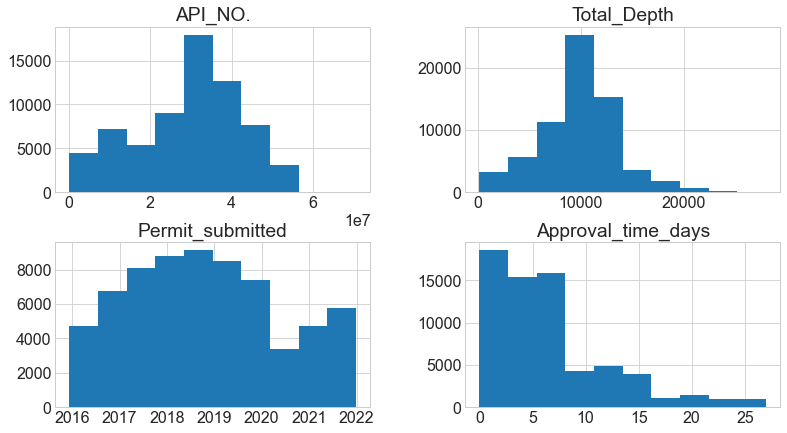

In [16]:
# draw distributions of numerical attributes
permits.hist()

- well depth is normally distributed
- notice a dropoff in permits in 2020--covid related downturn, for sure
- some of the permits were submitted as early as 2012
- almost all approval times were a matter of a couple of days, with a couple of outliers
- not familiar with the meaning of the status or api number, would be good to investigate

<AxesSubplot:>

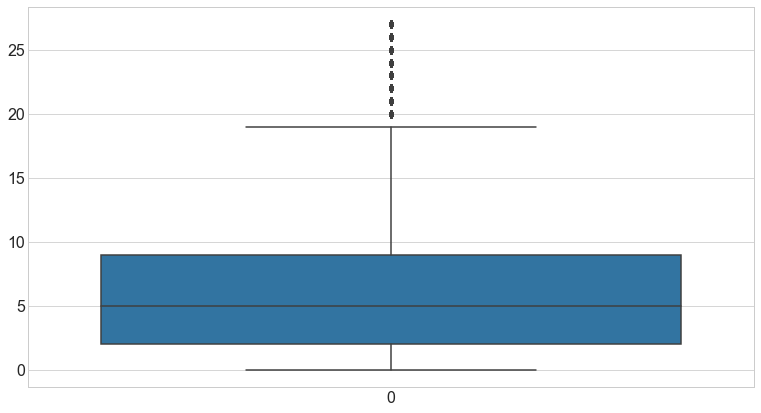

In [17]:
# a boxplot oof the approval time for all permits (many outliers were handled in wrangle)
sns.boxplot(data=permits.Approval_time_days)

In [18]:
# permits = wrangle_module.remove_outliers(permits, 1.5, ['Approval_time_days'])
# permits.hist()

- the remove outliers feature, which i will implement in the wrangle_module, takes care of those extreme approval times, and hence the early permit submissions

In [19]:
# list columns to help copy/paste in subsequent cells
permits.columns

Index(['API_NO.', 'Operator_Name_Number', 'Lease_Name', 'Well', 'District',
       'County', 'Wellbore_Profile', 'Filing_Purpose', 'Amend', 'Total_Depth',
       'Current_Queue', 'Permit_submitted', 'Approval_time_days', 'SHALE',
       'Depth_bin'],
      dtype='object')

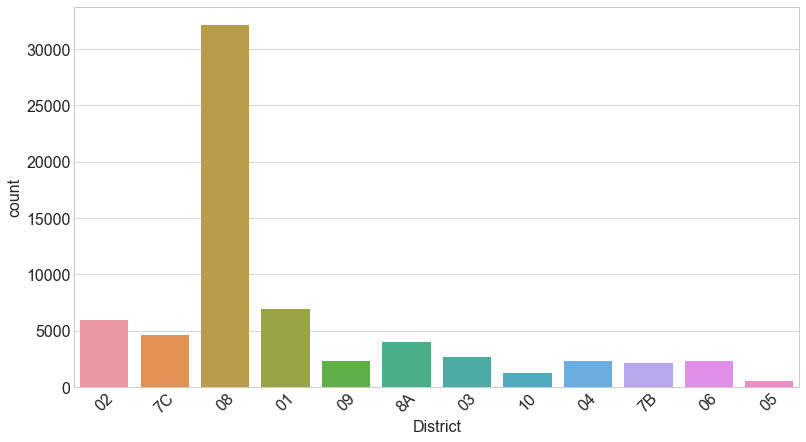

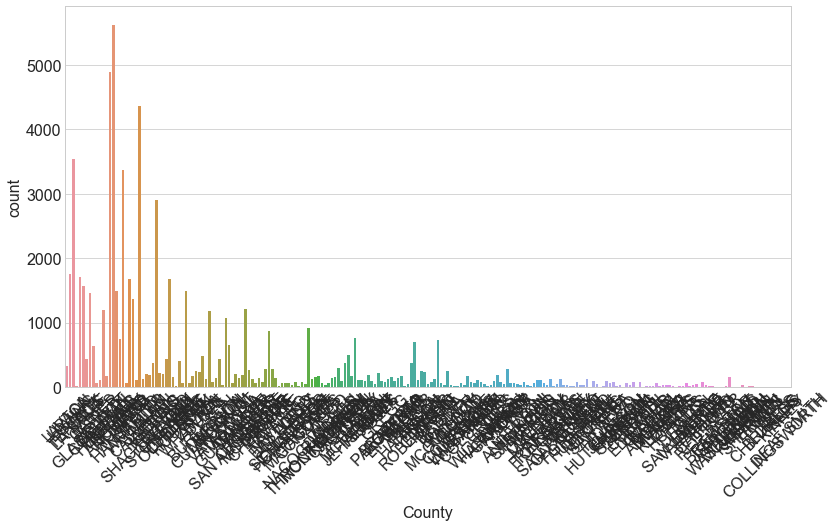

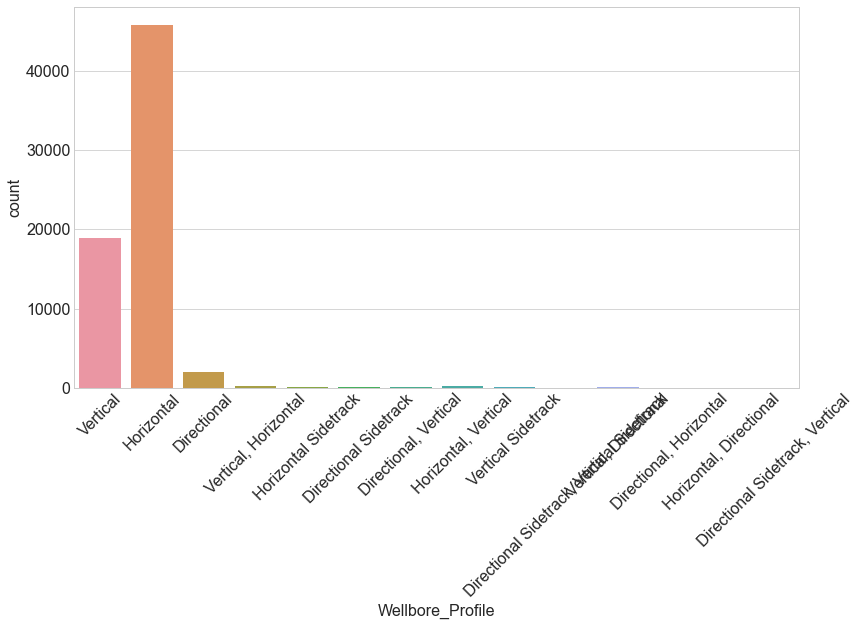

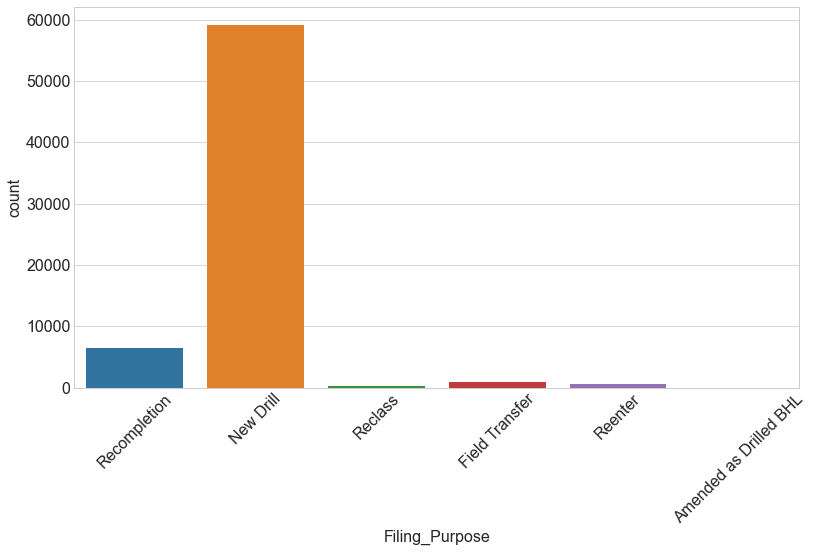

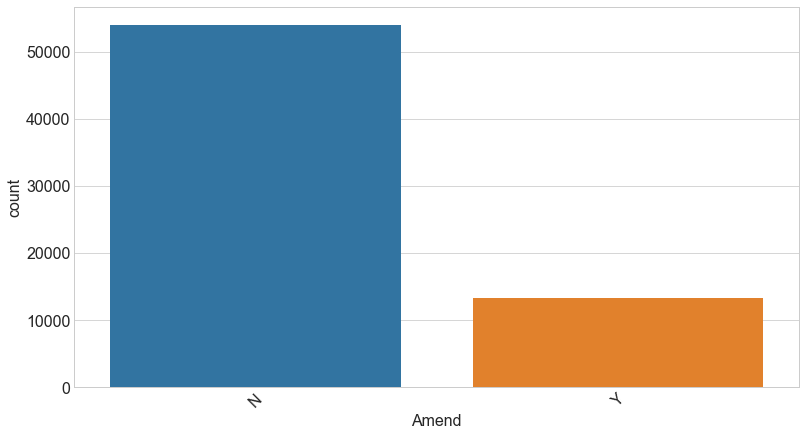

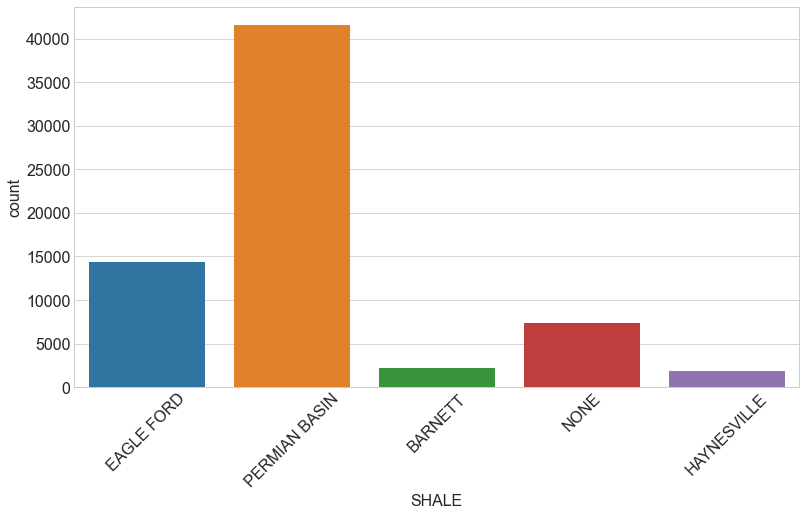

In [20]:
# define discrete variables for graphing purposes
disc_vars = ['District', 'County','Wellbore_Profile', 'Filing_Purpose', 'Amend','SHALE']
# for loop to graph the distribution all discrete variables
for var in disc_vars:
    plt.figure()
    sns.countplot(x=var,data=permits)
    plt.xticks(rotation = 45)

- District 8 is far and away the biggest for drilling permits
- There are six counties with considerably higher permitting--explore this more
- Horizontal wells are surprisingly the most common for permitting, followed by vertical.  Presumably due to the prevalence of fracking
- Almost everything is new drilling--consider dropping the rest of the filing purposes
- Relatively few ammended permits, but enough to take into account. Explo further?
- The Permian is far and away the highest area for permitting, followed by the eagleford shale.  

<AxesSubplot:xlabel='Permit_approved', ylabel='Approval_time_days'>

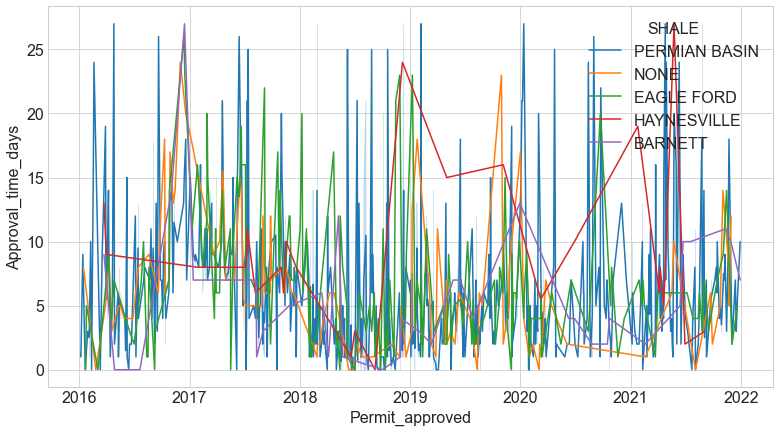

In [21]:
# create a sample to unburden the processing load for the following visual
temp = permits.sample(1000)
# a time-series type plot of approval time hued by shale
sns.lineplot(data=temp,x=temp.index, y= 'Approval_time_days', hue = 'SHALE')

- Nothing too helpful in this graph; time series is not likely to be an analytical method I refer to frequently in this notebook

In [22]:
# a list of the 50 counties with the fewest permit approvals
permits.County.value_counts().tail(50)

UPSHUR           19
JOHNSON          19
TITUS            18
FOARD            18
TRINITY          17
BAYLOR           17
JEFF DAVIS       17
HALE             17
COMANCHE         17
LUBBOCK          17
OLDHAM           17
NAVARRO          17
MOTLEY           16
ARANSAS          14
SHERMAN          13
MORRIS           12
SAN JACINTO      12
TERRELL          12
FALLS            11
WILLACY          10
MENARD           10
LYNN             10
WILLIAMSON        9
RED RIVER         8
GRAY              7
ERATH             6
PRESIDIO          6
FRANKLIN          5
MCLENNAN          5
KAUFMAN           4
CAMERON           4
HILL              3
CHILDRESS         3
SAN SABA          3
HOPKINS           3
HALL              3
HUNT              2
ELLIS             2
SABINE            2
TRAVIS            2
BREWSTER          1
FLOYD             1
DEAF SMITH        1
COLLINGSWORTH     1
MILLS             1
BELL              1
FANNIN            1
BRISCOE           1
CORYELL           1
KINNEY            1


In [23]:
# a list of the 5 counties with the most permit approvals
permits.County.value_counts().head(5)

REEVES     5627
MIDLAND    4883
MARTIN     4361
LOVING     3539
HOWARD     3364
Name: County, dtype: int64

### The top counties by permit requests:
- REEVES      5627
- MIDLAND     4883
- MARTIN      4361
- LOVING      3539
- HOWARD      3364
- KARNES      2903

<AxesSubplot:>

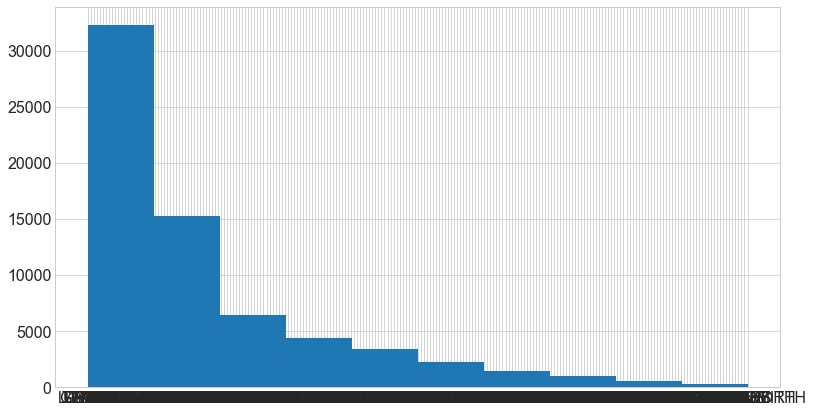

In [24]:
# the distribution of permit approvals by county. 
permits.County.hist()

- A few counties at the top occupy the vast majority of permit approvals

<AxesSubplot:xlabel='Permit_approved'>

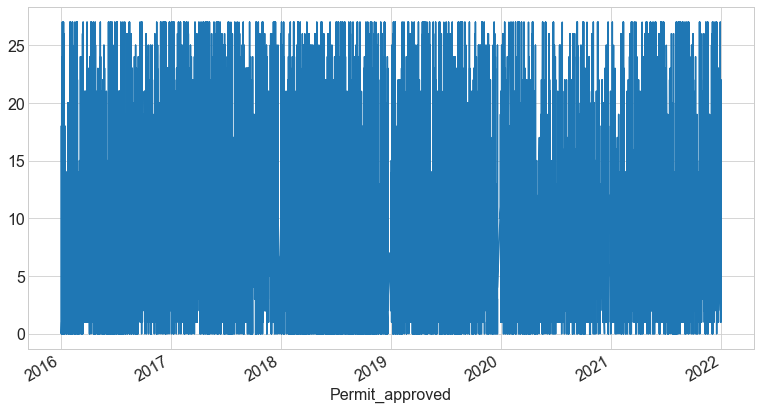

In [25]:
# A time series plot of approval times over the years
y = permits.Approval_time_days
y.plot()

- Nothing noteworthy, except a little bit of white in 2020: the pandemic slowdown

## Splitting , Encoding and Scaling the data here for further explo
- for the time being, i will not pursue the time series analysis perspective and will do a typical split, pending further exploration

In [26]:
# Encoding permits using the function in my wrangle module
permits = wrangle_module.encode_permits(permits)

In [27]:
# Creating splits for different uses later.  Also from my wrangle module
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = \
wrangle_module.split_permits(permits)


In [28]:
# Scaling my dfs; the y_ dfs were not actually scaled in this analysis, and so those
# dataframes are superfluous until removed at a later time.
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle_module.scale_permits(train,validate,test)

/Users/brianclements/codeup-data-science/Individual_Project/wrangle_module.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Depth_scaled'] = scaler.transform(test[['Total_Depth']])


In [29]:
# checking on the shape of the variouos dfs
train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, \
X_validate.shape, y_validate.shape, X_test.shape, y_test.shape, train_scaled.shape, \
X_train_scaled.shape, y_train_scaled.shape, validate_scaled.shape, \
X_validate_scaled.shape, y_validate_scaled.shape, test_scaled.shape, \
X_test_scaled.shape, y_test_scaled.shape

((37718, 33),
 (16166, 33),
 (13471, 33),
 (37718, 31),
 (37718, 1),
 (16166, 31),
 (16166, 1),
 (13471, 31),
 (13471, 1),
 (37718, 32),
 (37718, 31),
 (37718, 1),
 (16166, 32),
 (16166, 31),
 (16166, 1),
 (13471, 32),
 (13471, 31),
 (13471, 1))

In [30]:
X_train_scaled.shape

(37718, 31)

In [31]:
train.head().T

Permit_approved,2018-11-07,2016-07-11,2016-11-10,2019-09-26,2016-09-26
API_NO.,38937764,46140376,16334012,25536606,17333081
Operator_Name_Number,NOBLE ENERGY INC (611665),APACHE CORPORATION (027200),CABOT OIL & GAS CORPORATION (121700),BPX OPERATING COMPANY (085408),"VERITAS ENERGY, LLC (884589)"
Lease_Name,WILD BILL HICKOK 205-206 UNIT B,CONNELL 48 WEST,THOMPSON RANCH,LONESOME DOVE A,BRYANS 26
Well,9H,2HM,11H,8H,1
District,08,7C,01,02,08
County,REEVES,UPTON,FRIO,KARNES,GLASSCOCK
Wellbore_Profile,Horizontal,Horizontal,Horizontal,Horizontal,Vertical
Filing_Purpose,New Drill,New Drill,New Drill,New Drill,Recompletion
Amend,N,N,N,N,N
Total_Depth,13000,10200,8300,11874,8500


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37718 entries, 2018-11-07 to 2017-11-03
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   API_NO.               37718 non-null  int64         
 1   Operator_Name_Number  37718 non-null  object        
 2   Lease_Name            37718 non-null  object        
 3   Well                  37718 non-null  object        
 4   District              37718 non-null  object        
 5   County                37718 non-null  object        
 6   Wellbore_Profile      37718 non-null  object        
 7   Filing_Purpose        37718 non-null  object        
 8   Amend                 37718 non-null  object        
 9   Total_Depth           37718 non-null  int64         
 10  Current_Queue         37718 non-null  object        
 11  Permit_submitted      37718 non-null  datetime64[ns]
 12  Approval_time_days    37718 non-null  int64         
 13 

### List some variables you want to plot against Approval_time_days
- SHALE
- Total_Depth
- Amend
- Filing_purpose
- Wellbore_Profile
- County
- District

### These are all categorical with the exception of Total_Depth



In [33]:
# using boolean masking to check the mean approval time for district 5
train[train.District == '05'].Approval_time_days.mean()

7.888178913738019

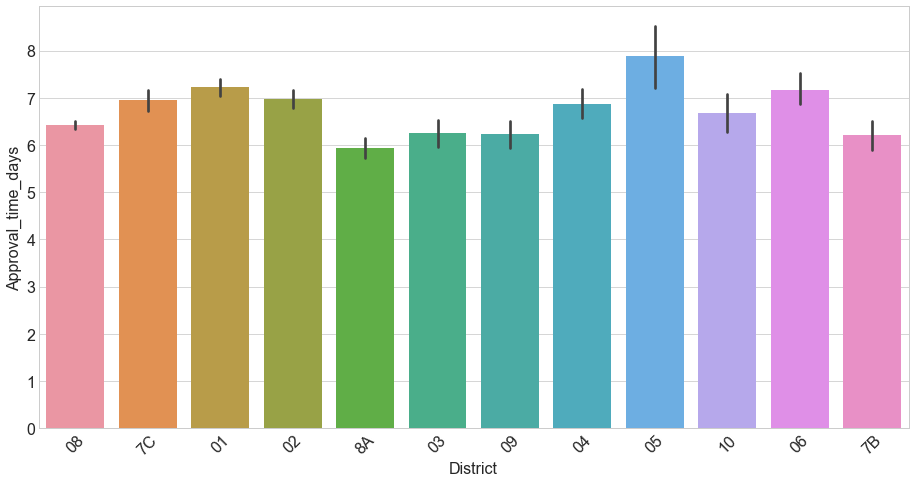

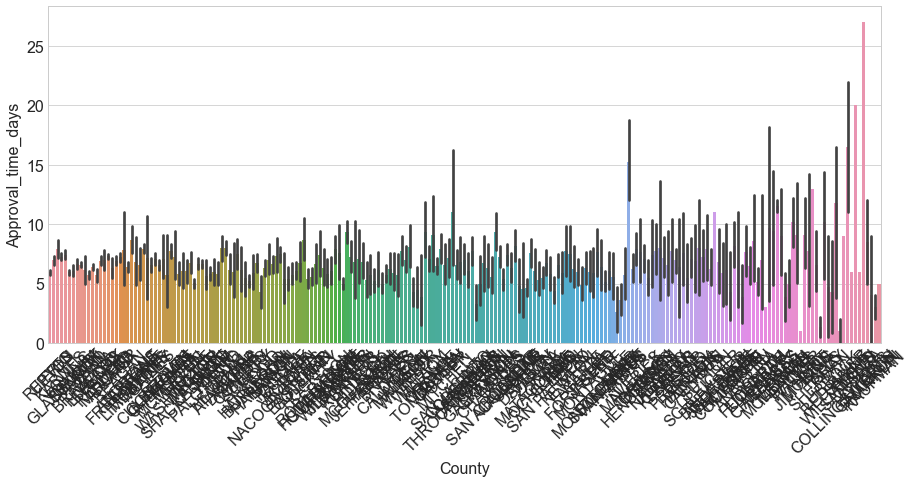

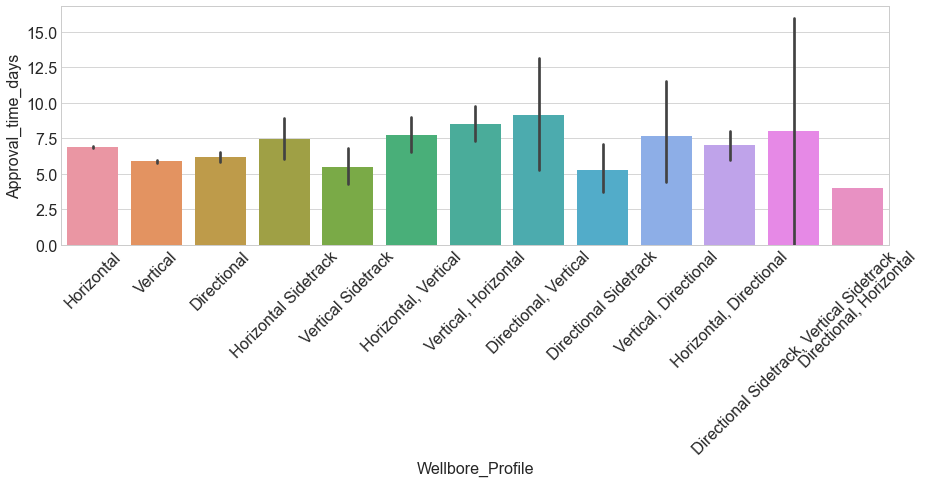

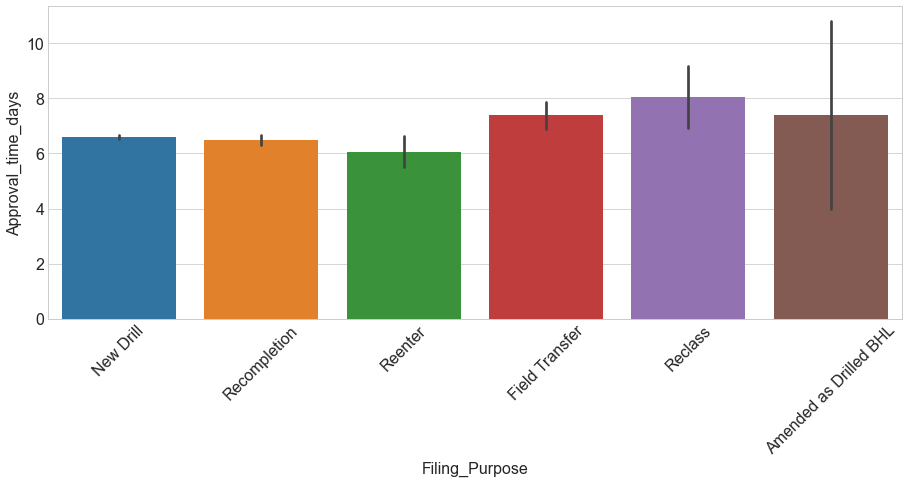

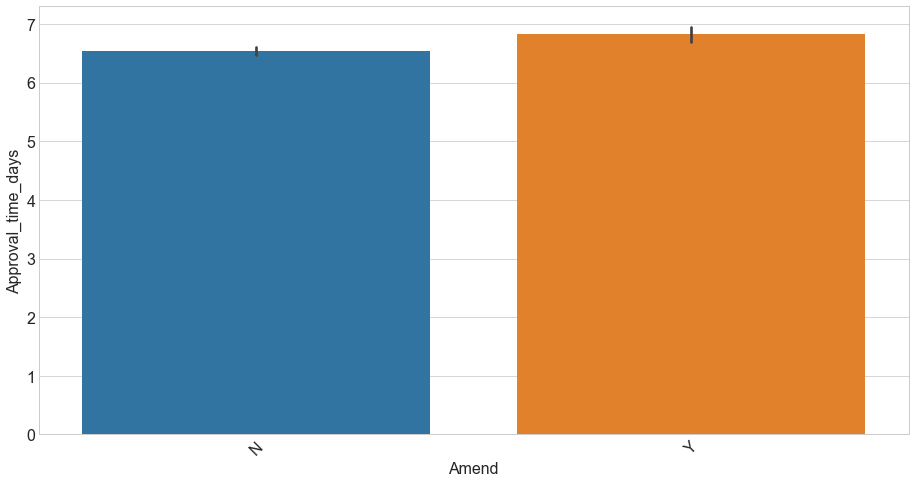

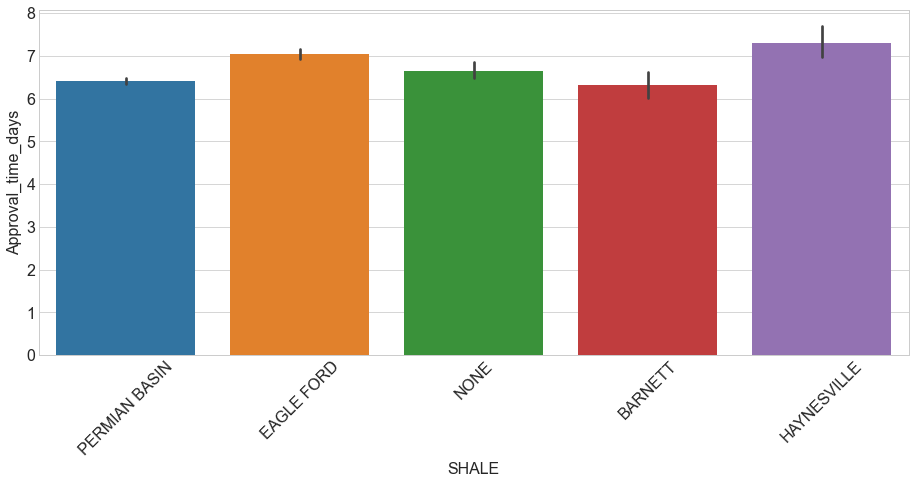

In [34]:
# using the discrete variables defined above to create barplots visualizing their 
# approval times
for var in disc_vars:
    plt.figure()
    sns.barplot(y= train.Approval_time_days, x=var,data=train)
    plt.xticks(rotation = 45)
    plt.tight_layout()

- District 5 has a slightly higher approval time, but this would need to be shown with some statistical testing
- There are a few particularly slow counties for permitting, it would be interesting to isolate and explore these
- filing purpose has virtually no relation to approval time, amend as well
- all shales have almost identical approval times; haynesville is a tiny bit more, but stats testing would be required to show this for sure
- directional horizontal wells have a slightly shorter approval time. However, there are only three wellbore profiles with significant numbers: horizontal, vertical, and directional.  To the extent the rest might need to be dropped

In [35]:
# a boolean mask checking the number of observations with 'directional, horizontal'
# wellbore profile.  There are only two
train[train.Wellbore_Profile == 'Directional, Horizontal']

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,...,District_04,District_05,District_06,District_08,District_09,District_10,District_7B,District_7C,District_8A,Depth_scaled
Permit_approved,,,,,,,,,,,,,,,,,,,,,
2018-10-29,25536206,ENCANA OIL & GAS(USA) INC. (251691),BURRIS UNIT,2H,02,KARNES,"Directional, Horizontal",New Drill,N,11000,...,0,0,0,0,0,0,0,0,0,0.389447


In [36]:
# a list of the number of observations for each wellbore profile
permits.Wellbore_Profile.value_counts()

Horizontal                                   45791
Vertical                                     18883
Directional                                   2014
Vertical, Horizontal                           182
Horizontal, Vertical                           163
Vertical Sidetrack                              86
Directional Sidetrack                           86
Horizontal Sidetrack                            84
Directional, Vertical                           31
Vertical, Directional                           25
Horizontal, Directional                          4
Directional, Horizontal                          3
Directional Sidetrack, Vertical Sidetrack        2
Directional Sidetrack, Vertical                  1
Name: Wellbore_Profile, dtype: int64

- Only 3 wellbore profiles dominate permit approvals: horizontal, vertical, and directional (which is by far the smallest of the three)

## Which counties are fastest/slowest for approvals?

In [37]:
# a list of counties with approval times above 15 days
train[train.Approval_time_days > 15].County.value_counts()#.head(10)

MIDLAND      279
REEVES       197
MARTIN       182
KARNES       158
HOWARD       118
            ... 
PARKER         1
ZAPATA         1
KNOX           1
VAL VERDE      1
BAYLOR         1
Name: County, Length: 170, dtype: int64

- 132 counties have average permitting times over 15 days

In [38]:
# The slowest 11 counties for average approval time, using a groupby and sorting, 
# displaying the last 11 only
train.groupby(by='County').Approval_time_days.mean().sort_values().tail(11)

County
DALLAS         10.153846
FALLS          10.200000
BREWSTER       11.000000
SAN JACINTO    11.000000
MCLENNAN       11.500000
RED RIVER      11.750000
HUNT           13.000000
TITUS          15.222222
SABINE         16.500000
FLOYD          20.000000
HOPKINS        27.000000
Name: Approval_time_days, dtype: float64

- The above is the list of counties with mean approval times over ten days

In [39]:
# the same, but the other (fast) end of the list
train.groupby(by='County').Approval_time_days.mean().sort_values().head(11)

County
HILL          1.000000
WILLIAMSON    1.000000
SHERMAN       1.333333
HALE          2.600000
KAUFMAN       3.000000
CHILDRESS     3.000000
WALLER        3.300000
LAMB          3.653846
MENARD        3.857143
WILLACY       3.875000
FOARD         3.888889
Name: Approval_time_days, dtype: float64

- And the counties with a mean approval time less than 4 days

In [40]:
# defining a list of 'quick' counties for use below
quick_counties = \
['HILL',
'WILLIAMSON',
'SHERMAN',
'HALE', 
'KAUFMAN',
'CHILDRESS',
'WALLER',
'LAMB',  
'MENARD',
'WILLACY',
'FOARD']

In [41]:
# for loop returning the number of observations for each quick county
for county in quick_counties:
    print(len(train[train.County == county]))

2
3
6
10
2
1
20
26
7
8
9


- There are exceedingly few permit approvals for these counties on the top end of the approval times

In [42]:
# define list of slow counties
slow_counties = ['DALLAS', 'FALLS', 'BREWSTER', 'SAN JACINTO', 'MCLENNAN', 'RED RIVER',
       'HUNT', 'TITUS', 'SABINE', 'FLOYD', 'HOPKINS']

In [43]:
# number of observations for counties in the slow list
for county in slow_counties:
    print(len(train[train.County == county]))

13
5
1
7
4
4
2
9
2
1
1


- likewise, there are few observations in the slow counties

In [44]:
# in contrast, the number of observations for REEVES county
len(train[train.County == 'REEVES'])

3191

In [45]:
# and the average turnaround for REEVES county
train[train.County == 'REEVES'].Approval_time_days.mean()

5.9335631463491065

- The fastest and slowest counties have very few permits being approved every year, on average; as a counter-example, refer to Reeves county, with its 3014 permits over the period studied (and 5.25 day average approval time)
- The county is going to be an issue to use for modeling due to dimensionaliy issues

## Do deeper wells experience longer approval times?

<AxesSubplot:xlabel='Approval_time_days', ylabel='Total_Depth'>

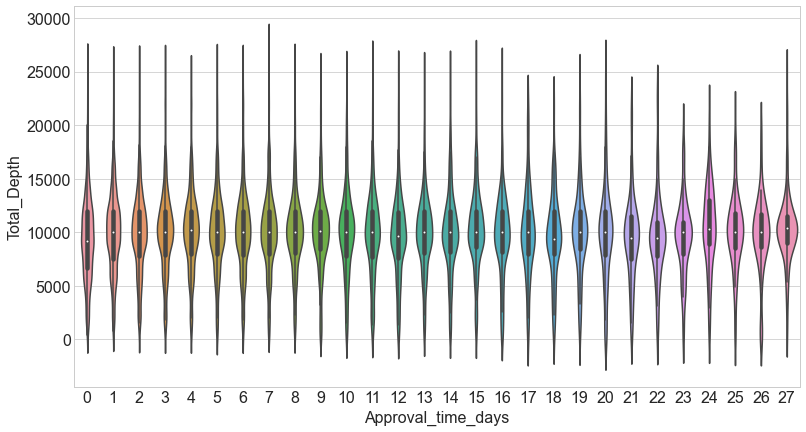

In [46]:
# violin plot of the well depth by approval time; 
# in this example, we're looking at approval time as a quasi-categorical value
sns.violinplot(data=train, y = 'Total_Depth', x = 'Approval_time_days')

- not a clear conclusion, this would be ripe for a levene then ANOVA test for differing variance

### Running a levene test to check on the variances between the populations above:

- H_0: The variances of the approval times by total depth are the same in all populations
- H_A: The variance in the populations is different

In [47]:
# a levene test of variance for depth by approval time
stats.levene(
train[train.Approval_time_days==0].Total_Depth,
train[train.Approval_time_days==1].Total_Depth,
train[train.Approval_time_days==2].Total_Depth,
train[train.Approval_time_days==3].Total_Depth,
train[train.Approval_time_days==4].Total_Depth,
train[train.Approval_time_days==5].Total_Depth,
train[train.Approval_time_days==6].Total_Depth,
train[train.Approval_time_days==7].Total_Depth,
train[train.Approval_time_days==8].Total_Depth,
train[train.Approval_time_days==9].Total_Depth,
train[train.Approval_time_days==10].Total_Depth,
train[train.Approval_time_days==11].Total_Depth,
train[train.Approval_time_days==12].Total_Depth,
train[train.Approval_time_days==13].Total_Depth,
train[train.Approval_time_days==14].Total_Depth,
train[train.Approval_time_days==15].Total_Depth,
train[train.Approval_time_days==16].Total_Depth,
train[train.Approval_time_days==17].Total_Depth,
train[train.Approval_time_days==18].Total_Depth,
train[train.Approval_time_days==19].Total_Depth,
)

LeveneResult(statistic=2.381505238770262, pvalue=0.000636176648755628)

- the variances are not equal

### Kruskal-Wallace testing (since the variances are unequal):

- H_O: The population means for the different well depths (by approval time) is the same
- H_a: These population means are different

In [48]:
# set alpha, the confidence level i will use for stats tests in this notebook
alpha = .05

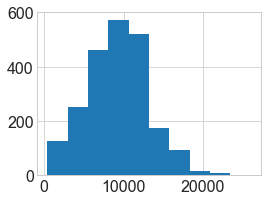

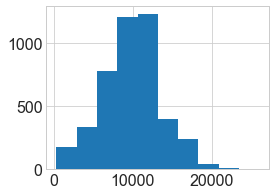

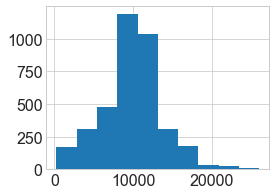

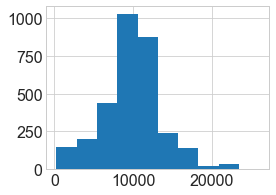

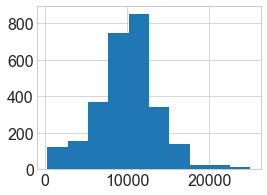

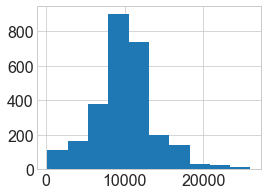

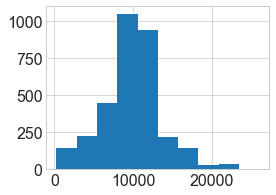

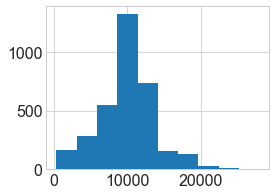

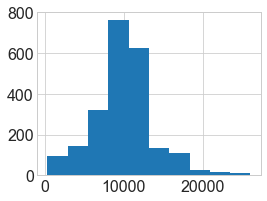

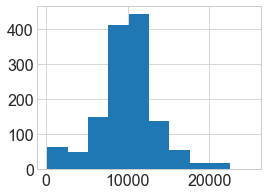

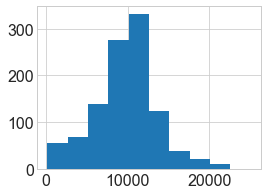

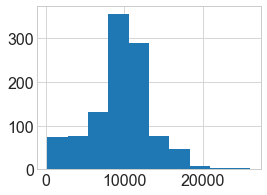

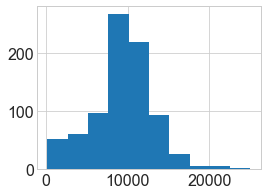

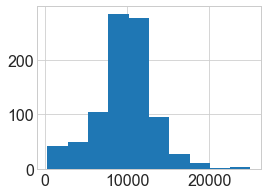

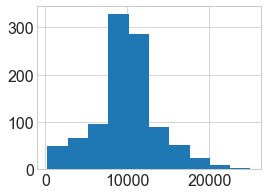

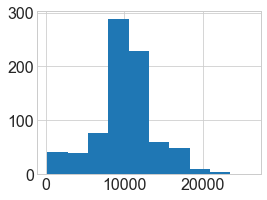

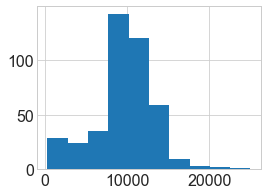

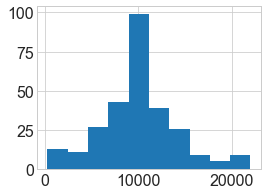

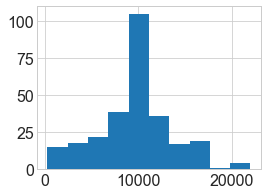

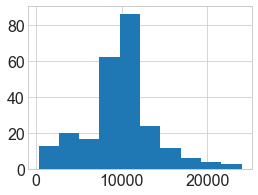

In [49]:
# plot the distributions of depth by approval time, to visually check they are
# normally distributed
for i in [train[train.Approval_time_days==0].Total_Depth,
train[train.Approval_time_days==1].Total_Depth,
train[train.Approval_time_days==2].Total_Depth,
train[train.Approval_time_days==3].Total_Depth,
train[train.Approval_time_days==4].Total_Depth,
train[train.Approval_time_days==5].Total_Depth,
train[train.Approval_time_days==6].Total_Depth,
train[train.Approval_time_days==7].Total_Depth,
train[train.Approval_time_days==8].Total_Depth,
train[train.Approval_time_days==9].Total_Depth,
train[train.Approval_time_days==10].Total_Depth,
train[train.Approval_time_days==11].Total_Depth,
train[train.Approval_time_days==12].Total_Depth,
train[train.Approval_time_days==13].Total_Depth,
train[train.Approval_time_days==14].Total_Depth,
train[train.Approval_time_days==15].Total_Depth,
train[train.Approval_time_days==16].Total_Depth,
train[train.Approval_time_days==17].Total_Depth,
train[train.Approval_time_days==18].Total_Depth,
train[train.Approval_time_days==19].Total_Depth]:
# train[train.Approval_time_days==20].Total_Depth,
# train[train.Approval_time_days==21].Total_Depth,
# train[train.Approval_time_days==22].Total_Depth,
# train[train.Approval_time_days==23].Total_Depth,
# train[train.Approval_time_days==24].Total_Depth,
# train[train.Approval_time_days==25].Total_Depth,
# train[train.Approval_time_days==26].Total_Depth,
# train[train.Approval_time_days==27].Total_Depth]:
    plt.figure(figsize=(4,3))
    i.hist()
    plt.show()

- These are generally normally distributed

In [50]:
# run the kruskal wallace test:
f, p = stats.kruskal(
train[train.Approval_time_days==0].Total_Depth,
train[train.Approval_time_days==1].Total_Depth,
train[train.Approval_time_days==2].Total_Depth,
train[train.Approval_time_days==3].Total_Depth,
train[train.Approval_time_days==4].Total_Depth,
train[train.Approval_time_days==5].Total_Depth,
train[train.Approval_time_days==6].Total_Depth,
train[train.Approval_time_days==7].Total_Depth,
train[train.Approval_time_days==8].Total_Depth,
train[train.Approval_time_days==9].Total_Depth,
train[train.Approval_time_days==10].Total_Depth,
train[train.Approval_time_days==11].Total_Depth,
train[train.Approval_time_days==12].Total_Depth,
train[train.Approval_time_days==13].Total_Depth,
train[train.Approval_time_days==14].Total_Depth,
train[train.Approval_time_days==15].Total_Depth,
train[train.Approval_time_days==16].Total_Depth,
train[train.Approval_time_days==17].Total_Depth,
train[train.Approval_time_days==18].Total_Depth,
train[train.Approval_time_days==19].Total_Depth)


f, p

(96.6395870969665, 2.164028878900564e-12)

In [51]:
# evaluate the results against alpha:
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


- I can proceed with the understanding that there is a difference in the means of Total_depth by approval time, although a linear correlation is not evident at this time

## Does the shale formation impact approval time?

In [52]:
# the number of observations for each shale formation
train.SHALE.value_counts()

PERMIAN BASIN    23272
EAGLE FORD        8027
NONE              4071
BARNETT           1308
HAYNESVILLE       1040
Name: SHALE, dtype: int64

In [53]:
# a list of the counties for copy/paste purposes
train.SHALE.value_counts().index

Index(['PERMIAN BASIN', 'EAGLE FORD', 'NONE', 'BARNETT', 'HAYNESVILLE'], dtype='object')

In [54]:
# Define the list of shale formations
shales = ['PERMIAN BASIN', 'EAGLE FORD', 'NONE', 'BARNETT', 'HAYNESVILLE']
# and print the average approval time for each
for shale in shales:
    print(train[train.SHALE == shale].Approval_time_days.mean())

6.417626332072877
7.038619658652049
6.653893392286907
6.3172782874617734
7.309615384615385


- The Barnett is fastest for approval; the Haynesville is slowest.  Stats testing here (and there is significant concern about noise in the data/limited differences between the means of the groups):

### Running a levene test to check on the variances between the populations above:

- H_0: The variances of the approval times by SHALE are the same in all populations
- H_A: The variance in the populations is different

In [55]:
# levene variance test like that run in an above cell:
stats.levene(
train[train.SHALE == 'PERMIAN BASIN'].Approval_time_days,
train[train.SHALE == 'EAGLE FORD'].Approval_time_days,
train[train.SHALE == 'NONE'].Approval_time_days,
train[train.SHALE == 'BARNETT'].Approval_time_days,
train[train.SHALE == 'HAYNESVILLE'].Approval_time_days
)

LeveneResult(statistic=2.2961516754377023, pvalue=0.05666758363395137)

- The null hypothesis cannot be rejected; the variances may be equal

In [56]:
# double checking each variance in the following several cells
train[train.SHALE == 'PERMIAN BASIN'].Approval_time_days.var(),

(31.996652042393958,)

In [57]:
train[train.SHALE == 'EAGLE FORD'].Approval_time_days.var(),

(31.46698578442854,)

In [58]:
train[train.SHALE == 'NONE'].Approval_time_days.var(),

(33.2435714471085,)

In [59]:
train[train.SHALE == 'BARNETT'].Approval_time_days.var(),

(31.168576519283413,)

In [60]:
train[train.SHALE == 'HAYNESVILLE'].Approval_time_days.var()

36.985855482342664

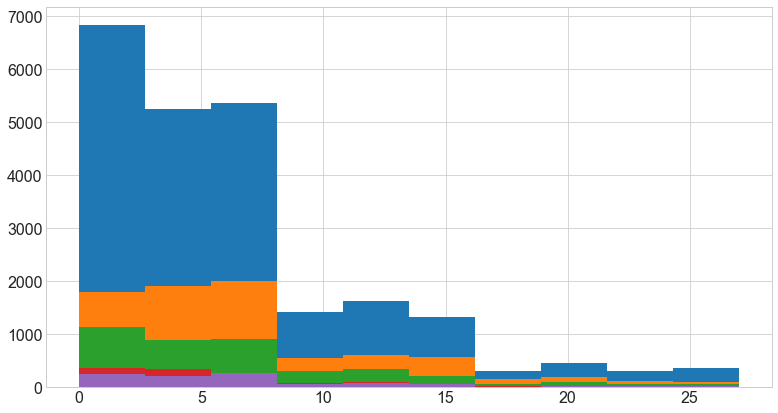

In [61]:
# a for loop to visualize the distribution approval times by shale formation
for i in [train[train.SHALE == 'PERMIAN BASIN'].Approval_time_days,
train[train.SHALE == 'EAGLE FORD'].Approval_time_days,
train[train.SHALE == 'NONE'].Approval_time_days,
train[train.SHALE == 'BARNETT'].Approval_time_days,
train[train.SHALE == 'HAYNESVILLE'].Approval_time_days]:
    i.hist()

- The approval times by shale are also not normally distributed

### ANOVA testing to follow (the target variable is continuous here):

- H_O: Shale is independent of the number of days to approval
- H_a: Shale plays a role in the length of time to approval

In [62]:
# running an anova test on the approval times by shale
f, p =stats.f_oneway(train[train.SHALE == 'PERMIAN BASIN'].Approval_time_days,
train[train.SHALE == 'EAGLE FORD'].Approval_time_days,
train[train.SHALE == 'NONE'].Approval_time_days,
train[train.SHALE == 'BARNETT'].Approval_time_days,
train[train.SHALE == 'HAYNESVILLE'].Approval_time_days)

f,p

(23.01709663829401, 5.050625333773221e-19)

- the tiny p value returned shows the null hypothesis can be rejected; proceeding with the understanding that the shale does in fact play some small role in the approval time in at least one of the shale formations

In [63]:
train.head()

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,...,District_04,District_05,District_06,District_08,District_09,District_10,District_7B,District_7C,District_8A,Depth_scaled
Permit_approved,,,,,,,,,,,,,,,,,,,,,
2018-11-07,38937764,NOBLE ENERGY INC (611665),WILD BILL HICKOK 205-206 UNIT B,9H,08,REEVES,Horizontal,New Drill,N,13000,...,0,0,0,1,0,0,0,0,0,0.461235
2016-07-11,46140376,APACHE CORPORATION (027200),CONNELL 48 WEST,2HM,7C,UPTON,Horizontal,New Drill,N,10200,...,0,0,0,0,0,0,0,1,0,0.360732
2016-11-10,16334012,CABOT OIL & GAS CORPORATION (121700),THOMPSON RANCH,11H,01,FRIO,Horizontal,New Drill,N,8300,...,0,0,0,0,0,0,0,0,0,0.292534
2019-09-26,25536606,BPX OPERATING COMPANY (085408),LONESOME DOVE A,8H,02,KARNES,Horizontal,New Drill,N,11874,...,0,0,0,0,0,0,0,0,0,0.420818
2016-09-26,17333081,"VERITAS ENERGY, LLC (884589)",BRYANS 26,1,08,GLASSCOCK,Vertical,Recompletion,N,8500,...,0,0,0,1,0,0,0,0,0,0.299713


In [64]:
# correlation table of the train df
train.corr()

,API_NO.,Total_Depth,Approval_time_days,SHALE_BARNETT,SHALE_EAGLE FORD,SHALE_HAYNESVILLE,SHALE_NONE,SHALE_PERMIAN BASIN,District_01,District_02,...,District_04,District_05,District_06,District_08,District_09,District_10,District_7B,District_7C,District_8A,Depth_scaled
API_NO.,1.000000,0.021581,-0.019070,-0.014529,-0.206523,0.034113,0.008818,0.162236,-0.203611,-0.117886,...,0.159518,0.040286,0.021374,0.056332,0.003566,0.023413,0.014150,0.180084,0.015879,0.021581
Total_Depth,0.021581,1.000000,0.008086,-0.251254,0.243883,0.076077,-0.296065,0.052580,-0.012371,0.267151,...,-0.019723,-0.020418,0.061778,0.200066,-0.268824,-0.090880,-0.257824,-0.074014,-0.180316,1.000000
Approval_time_days,-0.019070,0.008086,1.000000,-0.009323,0.040520,0.021164,0.003524,-0.039986,0.037350,0.021109,...,0.009172,0.020824,0.019315,-0.030773,-0.012553,0.001769,-0.012123,0.017104,-0.029355,0.008086
SHALE_BARNETT,-0.014529,-0.251254,-0.009323,1.000000,-0.098550,-0.031916,-0.065928,-0.240567,-0.064512,-0.058806,...,-0.035409,0.203095,-0.035981,-0.180563,0.653813,-0.026905,0.207065,-0.052546,-0.047228,-0.251254
SHALE_EAGLE FORD,-0.206523,0.243883,0.040520,-0.098550,1.000000,-0.087554,-0.180860,-0.659944,0.612993,0.471059,...,0.173423,0.008846,-0.098706,-0.495336,-0.099715,-0.073807,-0.093235,-0.144147,-0.129561,0.243883
SHALE_HAYNESVILLE,0.034113,0.076077,0.021164,-0.031916,-0.087554,1.000000,-0.058572,-0.213726,-0.057314,-0.052245,...,-0.031458,-0.015404,0.887020,-0.160417,-0.032293,-0.023903,-0.030195,-0.046683,-0.041959,0.076077
SHALE_NONE,0.008818,-0.296065,0.003524,-0.065928,-0.180860,-0.058572,1.000000,-0.441490,-0.079178,0.057822,...,0.180198,0.058600,0.060803,-0.331370,0.144389,0.408092,0.189438,-0.096432,-0.086674,-0.296065
SHALE_PERMIAN BASIN,0.162236,0.052580,-0.039986,-0.240567,-0.659944,-0.213726,-0.441490,1.000000,-0.421997,-0.393796,...,-0.237116,-0.116105,-0.240948,0.750572,-0.243411,-0.180168,-0.110183,0.218423,0.196321,0.052580
District_01,-0.203611,-0.012371,0.037350,-0.064512,0.612993,-0.057314,-0.079178,-0.421997,1.000000,-0.105603,...,-0.063587,-0.031136,-0.064615,-0.324254,-0.065275,-0.048315,-0.061033,-0.094361,-0.084813,-0.012371
District_02,-0.117886,0.267151,0.021109,-0.058806,0.471059,-0.052245,0.057822,-0.393796,-0.105603,1.000000,...,-0.057962,-0.028382,-0.058899,-0.295572,-0.059501,-0.044042,-0.055635,-0.086014,-0.077311,0.267151


- Basically no information to be gleaned here

In [65]:
train.head(1).T

Permit_approved,2018-11-07
API_NO.,38937764
Operator_Name_Number,NOBLE ENERGY INC (611665)
Lease_Name,WILD BILL HICKOK 205-206 UNIT B
Well,9H
District,08
County,REEVES
Wellbore_Profile,Horizontal
Filing_Purpose,New Drill
Amend,N
Total_Depth,13000


<AxesSubplot:xlabel='Depth_bin', ylabel='Approval_time_days'>

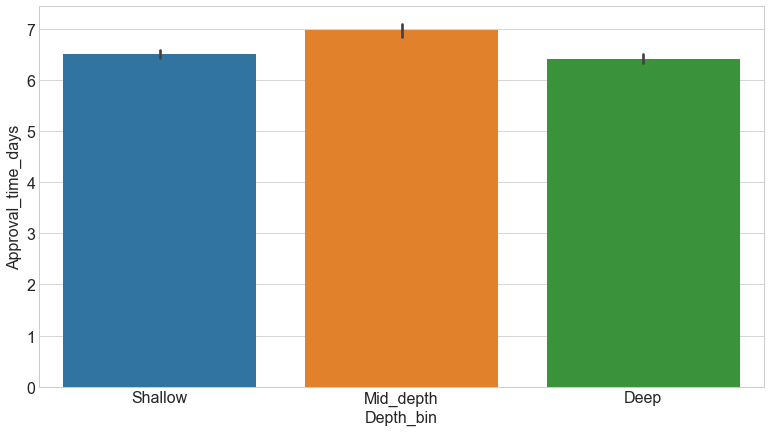

In [66]:
# a seaborn barplot to visualize the approval time for each depth bin
sns.barplot(data=train,x='Depth_bin',y= 'Approval_time_days')

- There isn't a significant difference from one to the next

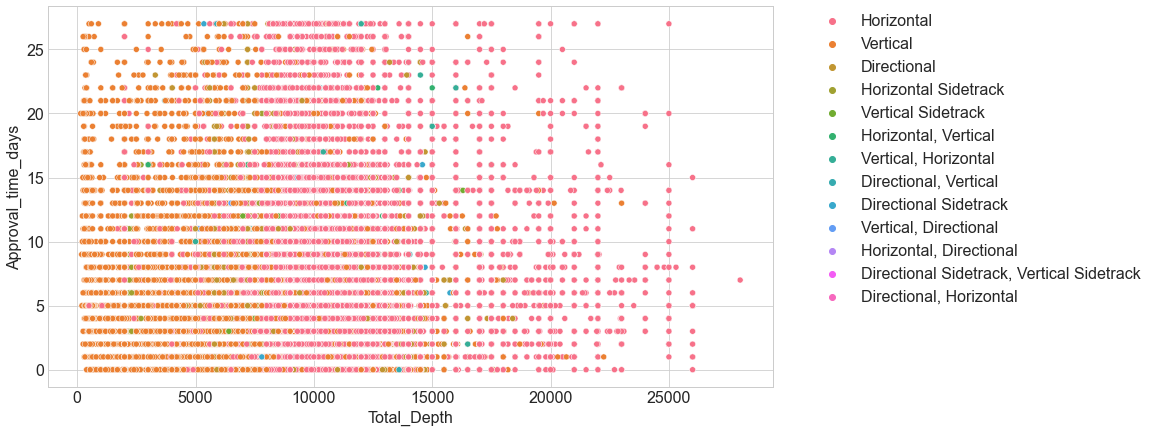

In [67]:
# A seaborn scatterplot to visualize approval time against depth
# The plot is hued on wellbore profile
sns.scatterplot(data=train,x='Total_Depth',y='Approval_time_days',hue='Wellbore_Profile')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


- There aren't so many deep well; the approval time is pretty homogeneous across the visual
- I previously established that vertical and horizontal wells dominate, by far, all wellbore profiles.

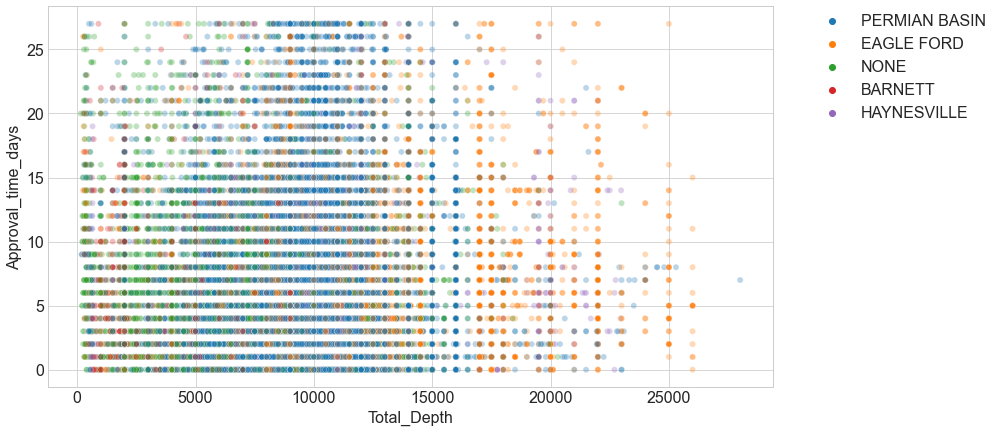

In [68]:
# a similar seaborn plot to the one above, hued on shale formation
sns.scatterplot(data=train,x='Total_Depth',y='Approval_time_days',hue='SHALE', alpha = .3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)



- Eagle Ford is represented more in the deeper end of the wells
- Fewer long approval times among the shallow wells
- The approval times, nevertheless, are pretty evenly distributed accross depths and shales

## Which district is the fastest for approval?

<AxesSubplot:xlabel='District', ylabel='Approval_time_days'>

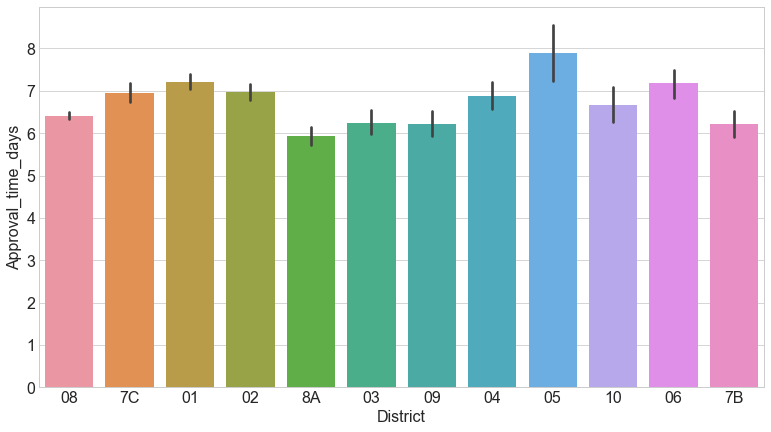

In [69]:
# a seaborn barplot of the approval times by district
sns.barplot(data=train,x='District',y='Approval_time_days')

- Every district has a 5 or 6 day approval time; districts 5 is just barely the fastest
- On the looks of it, there doesn't seem to be evidence supporting a strong relationship here.

# Modeling

### Baseline

MEAN will be used as the baseline

### Features

Feature engineering will not be part of my modeling

### All the X_train/validate/test_scaled are scaled from X_train/validate/test

### X_train/validate/test_model are likewise scaled

### The model is using an unscaled target variable, and therefore the RMSE will be given in days (which is the unit of the target variable)

(array([10381.,  8609.,  8832.,  2416.,  2784.,  2222.,   557.,   815.,
          541.,   561.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

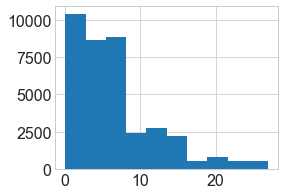

In [75]:
# visualize the distribution of y_train
plt.figure(figsize=(4,3))
plt.hist(y_train)

- Approval times are clearly not normally distributed

In [74]:
# Calculate the mean approval time of the y_train
y_train_scaled.Approval_time_days.mean()

6.596399597009386

- The above is the average approval time, i.e. the baseline for modeling

In [77]:
import model
# Create dataframes for modeling purposes from the model module. Just dropping all 
# columns except the scaled depth and the encoded districts and shales
X_train_model, X_validate_model, X_test_model = \
model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [78]:
# 1. Predict tax_value_pred_mean
# I create here new columns in the y_ data sets to hold the baseline value I am working with.
approval_time_pred_mean = y_train.Approval_time_days.mean()
y_train['Approval_time_pred_mean'] = round(approval_time_pred_mean, 2)
y_validate['Approval_time_pred_mean'] = round(approval_time_pred_mean,2)
y_test['Approval_time_pred_mean'] = round(approval_time_pred_mean,2)

In [79]:
# 2. RMSE of tax_value_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train.Approval_time_days,
                                y_train.Approval_time_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.Approval_time_days, y_validate.Approval_time_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  5.67 
Validate/Out-of-Sample:  5.6


In [80]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,5.67463,5.59545


In [81]:
# assigning and displaying the evaluation df for the various models i've run
# in my model module
metric_df = model.run_all_models(X_train_model, y_train, X_validate_model, y_validate, X_test_model, metric_df)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,5.674630,5.595450
1,OLS Regressor,5.661146,5.586228
2,Lasso_alpha1,5.674629,5.595407
3,glm_compound,5.660915,5.585307
4,quadratic_deg2,5.652545,5.578995
5,quadratic_deg3,5.649677,5.574972


- the third degree polynomial regression is returning the best result, and will be the model used on the test dataset

### Model evaluation

In [82]:
# import from sklearn to create polynomial features for running the model on test
from sklearn.preprocessing import PolynomialFeatures

# Make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=3)

# Fit and transform X_train_model (which is scaled)
X_train_degree3 = pf.fit_transform(X_train_model)

# Transform X_validate_model & X_test_model
X_validate_degree3 = pf.transform(X_validate_model)
X_test_degree3 =  pf.transform(X_test_model)

In [84]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
# Create the model object
lm2 = LinearRegression()

# Fit the model to our test data. 
lm2.fit(X_test_degree3, y_test.Approval_time_days)

# Create a column in the y_test dataframe to hold the polynomial regression prediction:
y_test['Approval_time_pred_lm2'] = lm2.predict(X_test_degree3)

# Evaluate by calculating its RMSE on test
rmse_test = mean_squared_error(y_test.Approval_time_days, y_test.Approval_time_pred_lm2) ** (1/2)
# A statement reminding us of the RMSE on the train and validate samples:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", metric_df.RMSE_train.iloc[5], 
      "\nValidation/Out-of-Sample: ", metric_df.RMSE_validate.iloc[5],)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  5.649676665982054 
Validation/Out-of-Sample:  5.574971850381146


In [85]:
# And a statement on the RMSE of the third degree polynomial model
print("RMSE for Polynomial Model, degrees=3\nTest/Out of Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=3
Test/Out of Sample:  5.639662829073366


In [86]:
# A simple calculation of the percent improvement over baseline:
(5.674630 - 5.639662) / 5.674630

0.006162163876763635

### Which is to say: the best model has beat baseline by 0.6 % (that's 6 tenths of one percent)

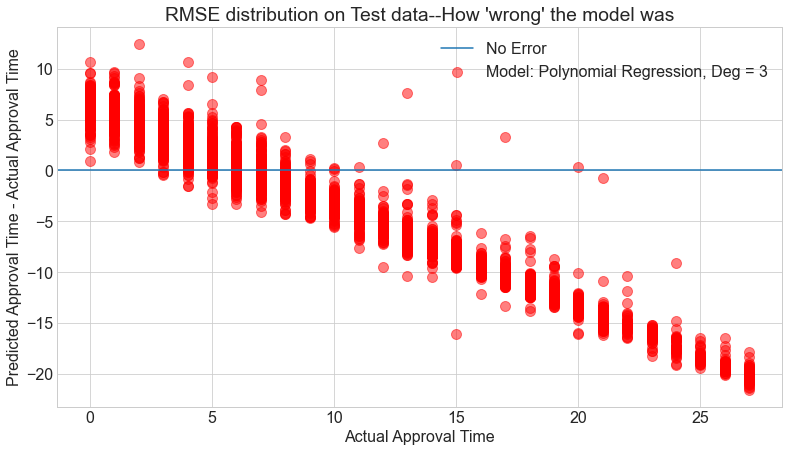

In [87]:
# A matplotlib scatterplot showing the residual error between predicted RMSE and actual tax value

# create a line representing no error
plt.axhline(label="No Error")
# plot approval times vs predicted approval times, with color and transparency defined
plt.scatter(y_test.Approval_time_days, y_test.Approval_time_pred_lm2 - y_test.Approval_time_days,\
            alpha=.5, color="red", s=100, label="Model: Polynomial Regression, Deg = 3")
# assign a legend
plt.legend()
# label the axes
plt.xlabel("Actual Approval Time")
plt.ylabel("Predicted Approval Time - Actual Approval Time")
# give the chart a title
plt.title("RMSE distribution on Test data--How 'wrong' the model was")
plt.show()